In [13]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [14]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

print_config()

MONAI version: 1.3.1rc5+13.g8c709de1
Numpy version: 1.26.4
Pytorch version: 2.3.0+cpu
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 8c709de12010929307060628a450741e1263e8e5
MONAI __file__: c:\Users\<username>\AppData\Local\Programs\Python\Python310\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: 5.3.0
Nibabel version: 5.2.1
scikit-image version: 0.23.2
scipy version: 1.13.0
Pillow version: 10.3.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.66.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.8
pandas version: 2.2.2
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSIO

In [15]:
import SimpleITK as sitk
import os
import glob

In [16]:
#datainput = 'c:\\Users\\OskarK\\Desktop\\AVT\\KiTS'

In [17]:
#dataoutput = 'c:\\Users\\OskarK\\Desktop\\My_AVT\\KiTS'

In [18]:
# for i in range(1,21):
#     merge = "K" + str(i)
#     input = os.path.join(datainput, merge,(merge + ".nrrd"))
#     output = os.path.join(dataoutput, merge, (merge + ".nii.gz"))
#     img = sitk.ReadImage(input)
#     sitk.WriteImage(img, output)

In [19]:
# for j in range(1,21):
#     merge = "K" + str(j)
#     input = os.path.join(datainput, merge,(merge + ".seg.nrrd"))
#     output = os.path.join(dataoutput, merge, (merge + ".seg.nii.gz"))
#     img = sitk.ReadImage(input)
#     sitk.WriteImage(img, output)

In [20]:
# datainput2 = 'c:\\Users\\OskarK\\Desktop\\AVT\\Rider2'

In [21]:
# dataoutput2 = 'c:\\Users\\OskarK\\Desktop\\My_AVT\\Rider2'

In [22]:
# for i in range(1,19):
#     os.makedirs('c:\\Users\\OskarK\\Desktop\\My_AVT\\Rider2\\R' + str(i))

In [23]:
# for i in range(1,19):
#     merge = "R" + str(i)
#     input2 = os.path.join(datainput2, merge,(merge + ".nrrd"))
#     output2 = os.path.join(dataoutput2, merge, (merge + ".nii.gz"))
#     img2 = sitk.ReadImage(input2)
#     sitk.WriteImage(img2, output2)

In [24]:
# for i in range(1,19):
#     merge = "R" + str(i)
#     input2 = os.path.join(datainput2, merge,(merge + ".seg.nrrd"))
#     output2 = os.path.join(dataoutput2, merge, (merge + ".seg.nii.gz"))
#     img2 = sitk.ReadImage(input2)
#     sitk.WriteImage(img2, output2)
#     print(i)

In [25]:
# for i in range(2,21):
#     input = "c:\\Users\\OskarK\\Desktop\\My_AVT\\KiTS\\K" + str(i) + "\\K" + str(i) + ".nii.gz"
#     output = "c:\\Users\\OskarK\\Desktop\\My_AVT\\imagesTr\\K" + str(i) + ".nii.gz"
#     os.rename(input, output)

In [26]:
# for i in range(1,19):
#     input = "c:\\Users\\OskarK\\Desktop\\My_AVT\\Rider2\\R" + str(i) + "\\R" + str(i) + ".nii.gz"
#     output = "c:\\Users\\OskarK\\Desktop\\My_AVT\\imagesTr\\R" + str(i) + ".nii.gz"
#     os.rename(input, output)

In [27]:
# for i in range(1,21):
#     input = "c:\\Users\\OskarK\\Desktop\\My_AVT\\KiTS\\K" + str(i) + "\\K" + str(i) + ".seg.nii.gz"
#     output = "c:\\Users\\OskarK\\Desktop\\My_AVT\\labelsTr\\K" + str(i) + ".seg.nii.gz"
#     os.rename(input, output)

In [28]:
# for i in range(1,19):
#     input = "c:\\Users\\OskarK\\Desktop\\My_AVT\\Rider2\\R" + str(i) + "\\R" + str(i) + ".seg.nii.gz"
#     output = "c:\\Users\\OskarK\\Desktop\\My_AVT\\labelsTr\\R" + str(i) + ".seg.nii.gz"
#     os.rename(input, output)

In [29]:
train_images = sorted(glob.glob(os.path.join("c:\\Users\\OskarK\\Desktop\\My_AVT\\", "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join("c:\\Users\\OskarK\\Desktop\\My_AVT\\", "labelsTr", "*.nii.gz")))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-8], data_dicts[-8:]

In [30]:
set_determinism(seed=0)

In [31]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)

monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.


In [32]:
import numpy as np

image shape: torch.Size([301, 301, 353]), label shape: torch.Size([301, 301, 353])


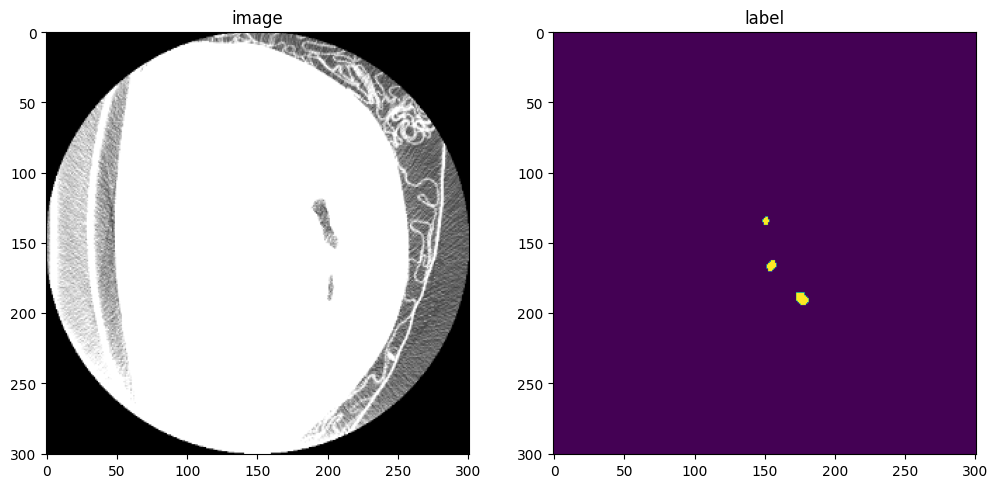

In [33]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80])
plt.show()

In [34]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
# train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 8/8 [01:26<00:00, 10.76s/it]


In [35]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cpu")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [40]:
max_epochs = 600
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), 'c:\\Users\\OskarK\\Desktop\\My_AVT\\best_metric_model.pth')
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/600
1/15, train_loss: 0.6426
2/15, train_loss: 0.6357
3/15, train_loss: 0.6414
4/15, train_loss: 0.6376
5/15, train_loss: 0.6414
6/15, train_loss: 0.6428
7/15, train_loss: 0.6440
8/15, train_loss: 0.6412
9/15, train_loss: 0.6417
10/15, train_loss: 0.6365
11/15, train_loss: 0.6392
12/15, train_loss: 0.6348
13/15, train_loss: 0.6463
14/15, train_loss: 0.6412
15/15, train_loss: 0.6334
epoch 1 average loss: 0.6400
----------
epoch 2/600
1/15, train_loss: 0.6288
2/15, train_loss: 0.6292
3/15, train_loss: 0.6369
4/15, train_loss: 0.6313
5/15, train_loss: 0.6178
6/15, train_loss: 0.6331
7/15, train_loss: 0.6180
8/15, train_loss: 0.6231
9/15, train_loss: 0.6323
10/15, train_loss: 0.6360
11/15, train_loss: 0.6418
12/15, train_loss: 0.6271
13/15, train_loss: 0.6264
14/15, train_loss: 0.6392
15/15, train_loss: 0.6329
epoch 2 average loss: 0.6303
saved new best metric model
current epoch: 2 current mean dice: 0.0021
best mean dice: 0.0021 at epoch: 2
----------
epoch 3/600
1/15,

In [41]:
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.5611 at epoch: 484


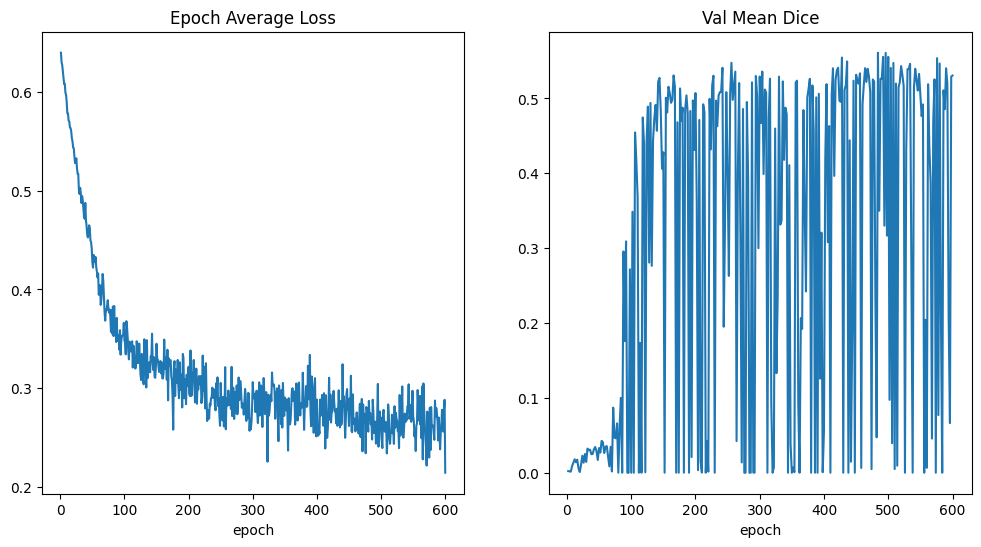

In [42]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

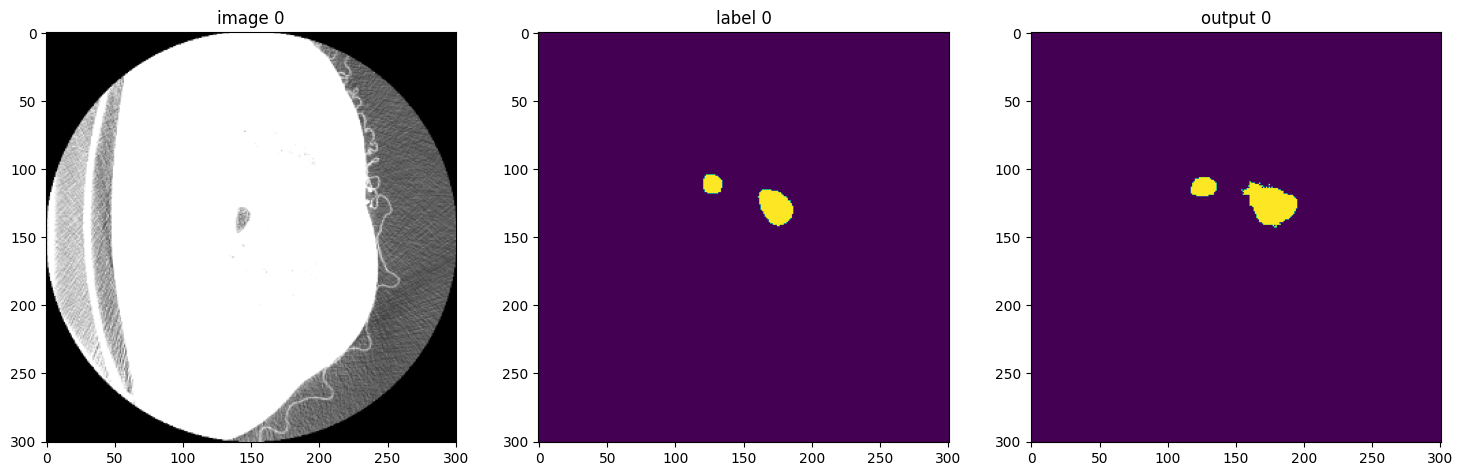

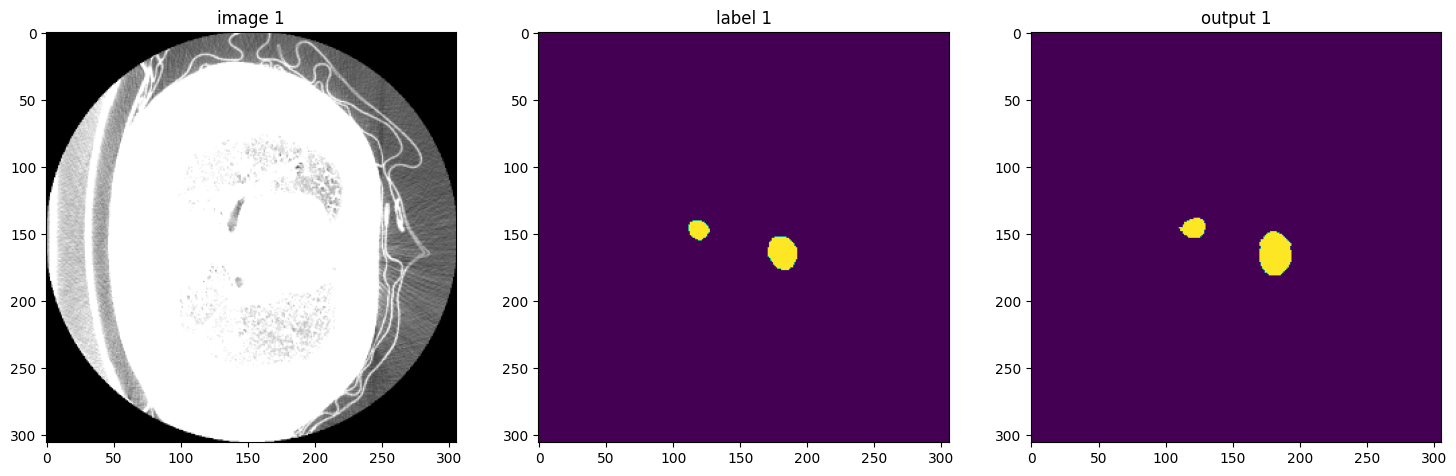

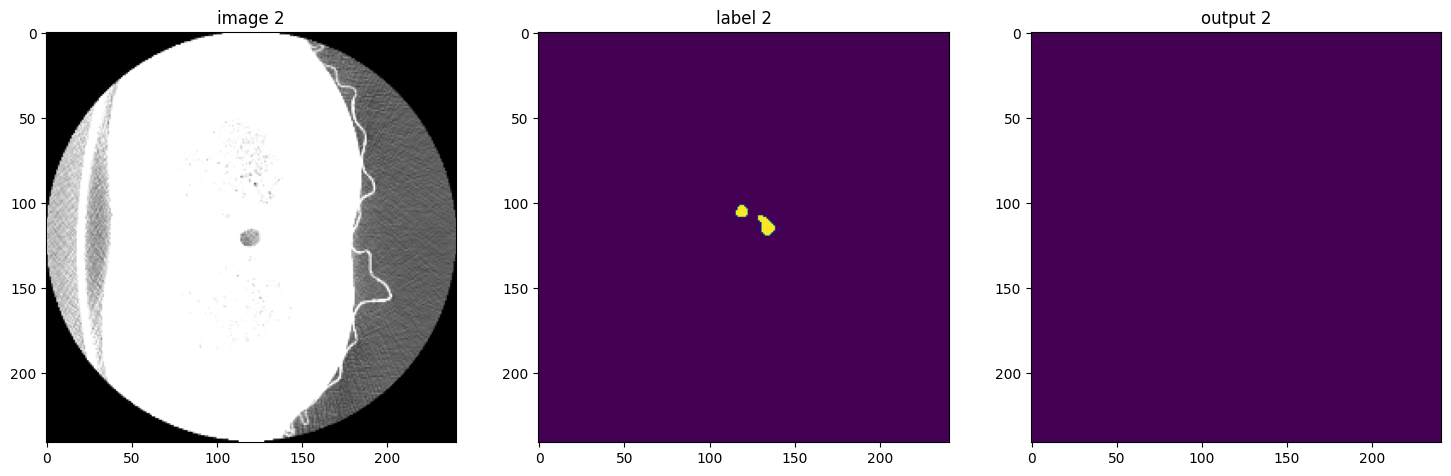

In [45]:
model.load_state_dict(torch.load('c:\\Users\\OskarK\\Desktop\\My_AVT\\best_metric_model.pth'))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 300], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 300])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 300])
        plt.show()
        if i == 2:
            break